In [1]:
%tensorflow_version 2.x
import tensorflow as tf

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117303 sha256=9c740284ea5374fc74f77ec63f45ba0a6c09c91c527aa3b8eb04a8bfb62b55fc
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

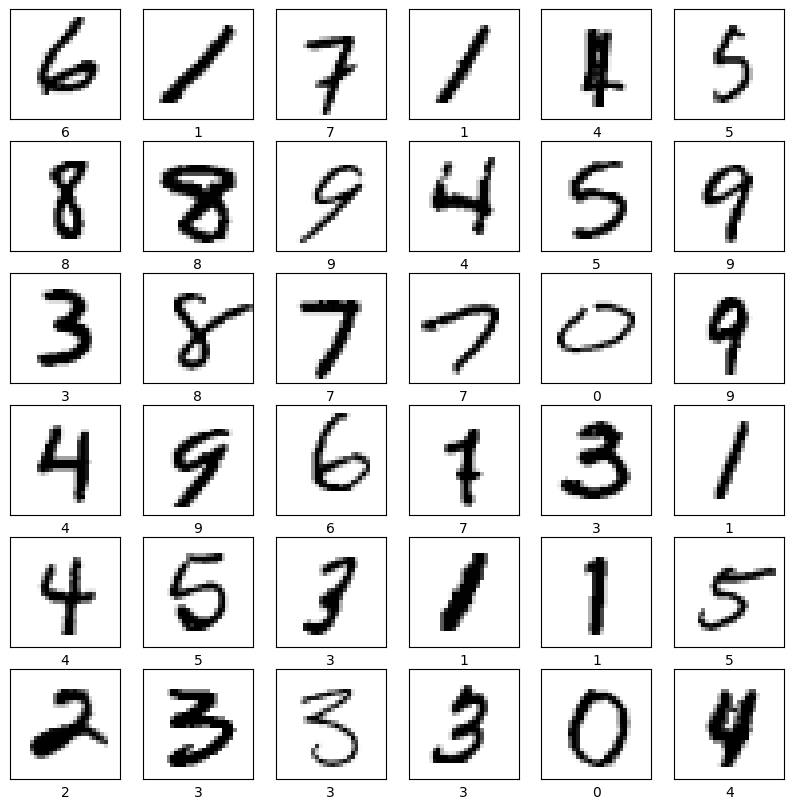

In [4]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

In [12]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(128, activation=tf.nn.relu),

      tf.keras.layers.Dense(10, activation=tf.nn.softmax)

  ])
  return fc_model

model = build_fc_model()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 50

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3721 - accuracy: 0.8960
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1993 - accuracy: 0.9433
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.1504 - accuracy: 0.9573
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1223 - accuracy: 0.9653
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9702
Test accuracy: 0.9702000021934509


1/1 [==============================] - 0s 133ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 24)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 36)        7812      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 36)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 900)               0         
                                                                 
 

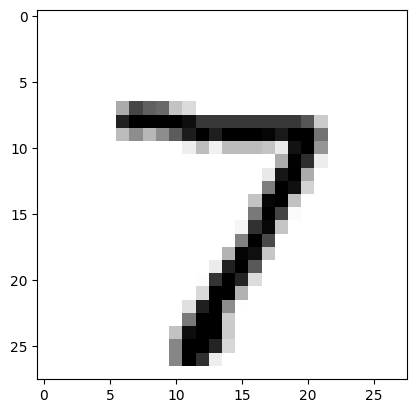

In [15]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),

        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),

        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    return cnn_model

cnn_model = build_cnn_model()
cnn_model.predict(train_images[[0]])
print(cnn_model.summary())

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)
predictions = cnn_model.predict(test_images)
predictions[0]
prediction = np.argmax(predictions[0])
print(prediction)
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)


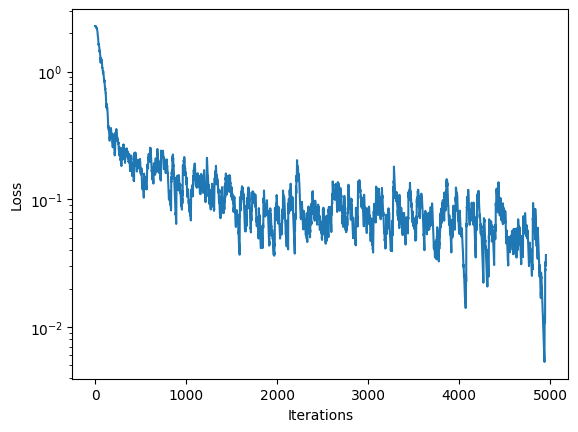

100%|██████████| 5000/5000 [01:34<00:00, 52.75it/s]


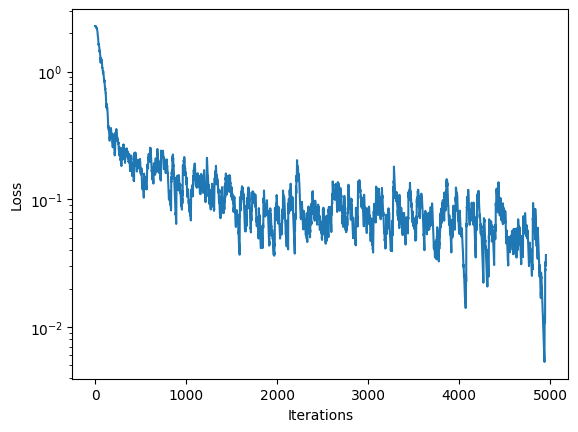

In [17]:
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  with tf.GradientTape() as tape:
    logits = cnn_model(images)

    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits)
  loss_history.append(loss_value.numpy().mean())
  plotter.plot(loss_history.get())

  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))